<a href="https://colab.research.google.com/github/ttsupra30/QM2/blob/main/Copy_of_QM_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Method Overview
**Objective**: This study examines the relationship between gambling expenditure and labour market conditions in Australia, focusing on unemployment rates across eight regions and at the national level. The analysis proceeds in two stages:

**Panel regression** to identify robust **correlations** while controlling for unobserved regional heterogeneity.

**Granger causality analysis** to examine lead–lag dynamics and temporal **causation**.

This two-step approach allows the study to separate contemporaneous association from dynamic predictive causality.

# 1. Data
**1.1 Unit of Analysis**

Cross-sectional unit: Australian regions i=1,…,8

Time unit: Annual observations t=1,…,T

Balanced panel : Each region observed over the same time span

**1.2 Key Variables**

*  Dependent or independent depends on the test direction
*   Gambling_it: Real per-capita gambling expenditure ($)
*   Unemp_it: Regional unemployment rate (%)

**1.3 Transformations**

Gambling → ln(Gambling_it)

**1.4 Control variables (X_it):**

Wage price index

Disposable income

Population

Time dummies to absorb national shocks



In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.2 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()

Saving QM2.csv to QM2.csv


In [4]:
# Read data
df = pd.read_csv('QM2.csv')
df.head()

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $)
0,ACT,1998–99,1739.17,69.25,6.00,11739.0
1,ACT,1999–00,1757.75,70.98,5.04,12528.0
2,ACT,2000–01,1761.04,73.50,4.58,12807.0
3,ACT,2001–02,1718.74,75.80,4.52,13462.0
4,ACT,2002–03,1723.14,78.40,4.26,14253.0


In [5]:
# Convert year columns
df.dropna(subset=['Year'], inplace=True)
df['year'] = df['Year'].str[-2:].astype(int) + 2000
df.loc[df['year'] > 2025, 'year'] -= 100
df

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $),year
0,ACT,1998–99,1739.17,69.25,6.00,11739.0,1999
1,ACT,1999–00,1757.75,70.98,5.04,12528.0,2000
2,ACT,2000–01,1761.04,73.50,4.58,12807.0,2001
3,ACT,2001–02,1718.74,75.80,4.52,13462.0,2002
4,ACT,2002–03,1723.14,78.40,4.26,14253.0,2003
...,...,...,...,...,...,...,...
203,WA,2019–20,787.04,132.48,6.02,126209.0,2020
204,WA,2020–21,971.28,134.43,6.09,129351.0,2021
205,WA,2021–22,946.83,137.35,3.81,137505.0,2022
206,WA,2022–23,925.11,142.58,3.56,144880.0,2023


In [6]:
# Relabel the columns
STATE = "State"
YEAR  = "year"
GAMB  = "Real per capita total gambling expenditure value ($)"
UNEMP = "Unemployment rate (%)"
WPI   = "Wage price index"

# Keep only necessary columns
df = df[[STATE, YEAR, GAMB, UNEMP, WPI]].copy()

# Ensure numeric data of all variables
df[[GAMB, UNEMP, WPI]] = df[[GAMB, UNEMP, WPI]].apply(pd.to_numeric, errors="coerce")

# Log gambling
df = df[df[GAMB] > 0]
df["log_gambling"] = np.log(df[GAMB])

# Drop missing and set panel index
df = df.dropna(subset=[STATE, YEAR, "log_gambling", UNEMP, WPI])
df = df.set_index([STATE, YEAR]).sort_index()
df

Real per capita total gambling expenditure value ($)  \
State year                                                         
ACT   1999                                            1739.17      
      2000                                            1757.75      
      2001                                            1761.04      
      2002                                            1718.74      
      2003                                            1723.14      
...                                                       ...      
WA    2020                                             787.04      
      2021                                             971.28      
      2022                                             946.83      
      2023                                             925.11      
      2024                                             896.41      

            Unemployment rate (%)  Wage price index  log_gambling  
State year                                                         
ACT   1999                   6.00             69.25      7.461163  
      2000                   5.04             70.98      7.471790  
      2001                   4.58             73.50      7.473660  
      2002                   4.52             75.80      7.449347  
      2003                   4.26             78.40      7.451903  
...                           ...               ...           ...  
WA    2020                   6.02            132.48      6.668279  
      2021                   6.09            134.43      6.878615  
      2022                   3.81            137.35      6.853120  
      2023                   3.56            142.58      6.829913  
      2024                   3.73            148.85      6.798398  

[208 rows x 4 columns]

# 3. Models
# 3.1 Time-series OLS + Panel Regression
**3.1.A Model A: Gambling leads unemployment**

*   Test of gambling → later unemployment




**Model A1: National time-series OLS (Australia as a whole)**

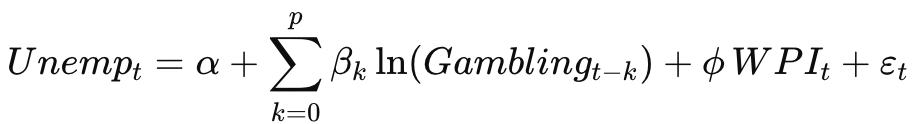

**Model A2: Single-region time-series OLS** (e.g. NSW only)

* Same equation - just applied to one region.

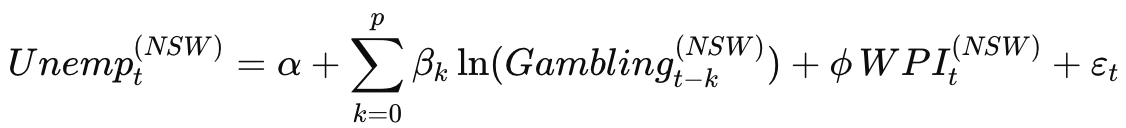

Both two times series OLS test for “Does gambling lead unemployment within this specific region over time?”

In [7]:
# 1) TIME-SERIES OLS (works for NATIONAL and any SINGLE region)

def ts_ols_modelA(ts_df, *, year_col=YEAR, p=1):
    """
    Input: one time series (one row per year), with columns:
      year_col, UNEMP, 'log_gambling', WPI
    Returns: (results, data_used)
    """
    d = ts_df[[year_col, UNEMP, "log_gambling", WPI]].dropna().sort_values(year_col).copy()

    for k in range(0, p + 1):
        d[f"g_L{k}"] = d["log_gambling"].shift(k)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [8]:
# Assuming STATE, YEAR, GAMB, UNEMP, WPI, and ts_ols_modelA are defined in previous cells
# Re-create df_flat and nat for national results, and nsw for NSW results for this cell's scope
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()
res_nat, _ = ts_ols_modelA(nat, year_col=YEAR, p=5) # p=1 for simplicity, can be changed

# Dictionary to store all model results
results = {}
results["National"] = res_nat

# Run time-series OLS for each state and store results
all_states = df_flat[STATE].unique()
for state_name in all_states:
    region_df = df_flat[df_flat[STATE] == state_name][[YEAR, UNEMP, "log_gambling", WPI]]
    res_region, _ = ts_ols_modelA(region_df, year_col=YEAR, p=5) # using p=1 as in National/NSW example
    results[state_name] = res_region

# Prepare the list of models for summary_col
model_order = ['National','NSW','VIC','QLD','SA','WA','TAS','ACT']
models = [results[name] for name in model_order]

table = summary_col(
    models,
    stars=True,
    float_format='%0.3f',
    model_names=model_order,
    info_dict={
        "N": lambda x: f"{int(x.nobs)}",
        "R²": lambda x: f"{x.rsquared:.3f}"
    }
)

print(table)


                  National    NSW      VIC       QLD         SA       WA       TAS       ACT   
-----------------------------------------------------------------------------------------------
const            13.802    89.261*** -56.042* 119.310*** 99.113*** -29.738  19.277*   24.868   
                 (30.962)  (8.691)   (28.974) (10.263)   (9.615)   (21.173) (11.040)  (17.278) 
g_L0             -0.452    1.389     -1.138*  -1.133*    -4.247*** -4.554   -2.604    -0.935   
                 (0.692)   (1.653)   (0.594)  (0.614)    (0.615)   (3.662)  (1.654)   (0.908)  
g_L1             -1.725*** -8.942*** 0.955**  -6.127***  -4.940*** 0.658    -4.329*** 1.489    
                 (0.492)   (2.823)   (0.412)  (1.100)    (0.854)   (3.348)  (0.456)   (0.977)  
g_L2             4.278***  -1.571*   1.677*   -3.774***  -1.159    1.859*   0.590     -4.364***
                 (0.408)   (0.830)   (1.004)  (0.726)    (1.205)   (1.092)  (0.936)   (0.577)  
g_L3             3.264***  6.068***  4.

In [9]:
# How to call them
# National time-series
# Make a national series by aggregating across states each year
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()
res_nat, used_nat = ts_ols_modelA(nat, year_col=YEAR, p=1) # change p here for different lags
print(res_nat.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.338
Model:                               OLS   Adj. R-squared:                  0.244
Method:                    Least Squares   F-statistic:                     3.704
Date:                   Mon, 29 Dec 2025   Prob (F-statistic):             0.0278
Time:                           21:32:48   Log-Likelihood:                -25.166
No. Observations:                     25   AIC:                             58.33
Df Residuals:                         21   BIC:                             63.21
Df Model:                              3                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [10]:
# How to call them
# Single region time-series (e.g., NSW)
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]] # change "NSW here for different region
res_nsw, used_nsw = ts_ols_modelA(region, year_col=YEAR, p=1) # change p here for different lags
print(res_nsw.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.614
Model:                               OLS   Adj. R-squared:                  0.559
Method:                    Least Squares   F-statistic:                     13.97
Date:                   Mon, 29 Dec 2025   Prob (F-statistic):           3.14e-05
Time:                           21:32:48   Log-Likelihood:                -14.273
No. Observations:                     25   AIC:                             36.55
Df Residuals:                         21   BIC:                             41.42
Df Model:                              3                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

**Intepret the Coefficient**

Note: Here I deliberately set k starting from 0, so that when k=0 we capture the contemporaneous effect, that is, how unemployment and gambling move within the same year.

In [11]:
import matplotlib.pyplot as plt

def plot_unemp_vs_lagged_gambling(ts_df, *, year_col=YEAR, lag=1, title=""):
    d = ts_df[[year_col, UNEMP, "log_gambling"]].dropna().sort_values(year_col).copy()
    d["g_lag"] = d["log_gambling"].shift(lag)
    d = d.dropna()

    plt.figure(figsize=(6,5))
    plt.scatter(d["g_lag"], d[UNEMP])
    b1, b0 = np.polyfit(d["g_lag"], d[UNEMP], 1)
    x = np.linspace(d["g_lag"].min(), d["g_lag"].max(), 100)
    plt.plot(x, b1*x + b0)

    plt.xlabel(f"log gambling (t−{lag})")
    plt.ylabel("Unemployment rate (%)")
    plt.title(title or f"Unemployment vs gambling lag {lag}")
    plt.tight_layout()
    plt.show()

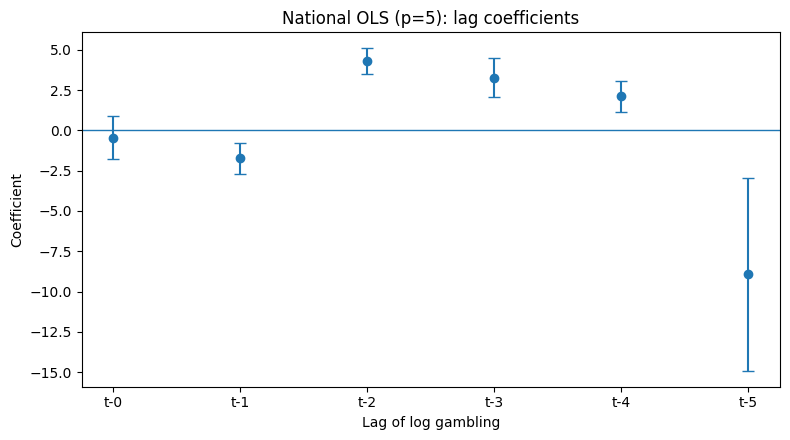

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ols_lag_coeffs(res, *, p, prefix="g_L", title="OLS coefficients by lag", ylab="Coefficient"):
    lags = list(range(0, p+1))
    names = [f"{prefix}{k}" for k in lags]

    coefs = np.array([res.params.get(n, np.nan) for n in names], dtype=float)
    ses   = np.array([res.bse.get(n, np.nan) for n in names], dtype=float)

    ci_low  = coefs - 1.96*ses
    ci_high = coefs + 1.96*ses

    x = np.arange(len(lags))

    plt.figure(figsize=(8,4.5))
    plt.axhline(0, linewidth=1)
    plt.errorbar(x, coefs, yerr=1.96*ses, fmt="o", capsize=4)
    plt.xticks(x, [f"t-{k}" for k in lags])
    plt.xlabel("Lag of log gambling")
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # If you want p=5:
res_nat5, used_nat5 = ts_ols_modelA(nat, year_col=YEAR, p=5)
plot_ols_lag_coeffs(res_nat5, p=5, title="National OLS (p=5): lag coefficients")


Figure X summarises the distributed-lag OLS estimates from the national time-series model with five lags of log gambling expenditure. Each point represents the estimated coefficient on gambling at lag
𝑡
−
𝑘
t−k, with 95% confidence intervals. The results indicate no robust contemporaneous relationship, but statistically significant associations at longer lags. In particular, gambling expenditure lagged one year is negatively associated with current unemployment, while positive associations emerge at lags of two to four years. This pattern suggests that the relationship between gambling behaviour and labour-market conditions is dynamic rather than immediate, motivating the subsequent Granger causality analysis.

Each point in Figure X represents the estimated OLS coefficient on log gambling expenditure at lag
𝑡
−
𝑘
t−k, measuring the association between unemployment in year
𝑡
t and a 1% change in gambling expenditure
𝑘
k years earlier, holding other lags and the wage price index constant.

each dot represents the coefficient beta, which tells you how unemployment today is associated with gambling at a particular lag, holding all other regressors constant.
The vertical lines are 95% confidence intervals around each coefficient.

They show:

how precisely each coefficient is estimated

whether the effect is statistically distinguishable from zero

If the bar crosses zero:

the effect is not statistically significant at ≈5%

If it does not cross zero:

the effect is statistically significant

This figure presents the estimated coefficients from a national lag OLS model relating unemployment to current and past gambling expenditure. The contemporaneous coefficient (
t−0) is small and statistically insignificant, implying that a 1% increase in gambling expenditure within the same year is associated with only a 0.005% decrease in unemployment. By contrast, the one-year lag (
t−1) is negative and statistically significant: a 1% increase in gambling expenditure in the previous year is associated with a 0.017% reduction in the unemployment rate.

At longer horizons, the relationship reverses. A 1% increase in gambling expenditure two years earlier (
t−2) is associated with a 0.043% increase in unemployment, while increases three and four years earlier (
t−3 and
t−4) are associated with increases of approximately 0.033% and 0.021%  respectively, all statistically significant. The five-year lag (
t−5) is negative but imprecisely estimated, with wide confidence intervals. This indicates substantial uncertainty at longer horizons. Overall, the results suggest that the relationship between gambling and unemployment is dynamic rather than immediate, with effects unfolding over several years.

Before dropna: (26, 3)
After dropna: (26, 3)


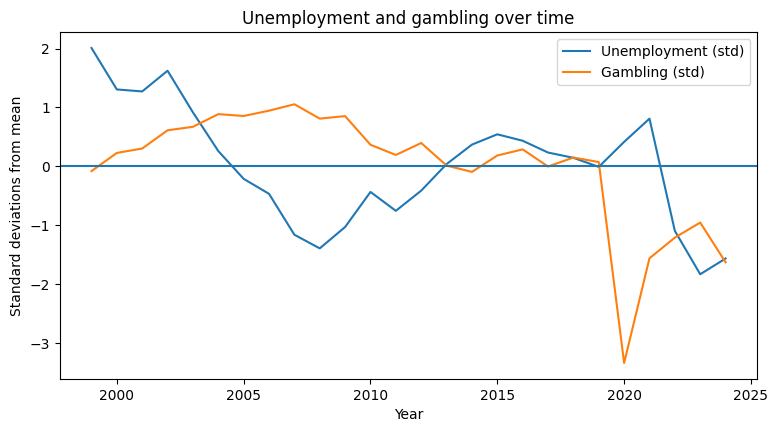

In [44]:
import matplotlib.pyplot as plt

d = nat[[YEAR, UNEMP, "log_gambling"]].copy()
print("Before dropna:", d.shape)

d = d.dropna().sort_values(YEAR)
print("After dropna:", d.shape)

# Standardise
d["unemp_z"] = (d[UNEMP] - d[UNEMP].mean()) / d[UNEMP].std()
d["gamb_z"]  = (d["log_gambling"] - d["log_gambling"].mean()) / d["log_gambling"].std()

plt.figure(figsize=(9,4.5))
plt.plot(d[YEAR], d["unemp_z"], label="Unemployment (std)")
plt.plot(d[YEAR], d["gamb_z"], label="Gambling (std)")
plt.axhline(0)
plt.xlabel("Year")
plt.ylabel("Standard deviations from mean")
plt.title("Unemployment and gambling over time")
plt.legend()
plt.show()

This figure plots national unemployment and real per-capita gambling expenditure over time. Both series are expressed in standard deviations from their respective means to facilitate comparison. The graph illustrates times when gambling and unemployment move in conjunction and times when they move apart, implying that their relationship unfolds over time rather than instantaneously. In the early 2000s, unemployment declines from above-average levels while gambling expenditure rises above its long-run mean, suggesting that gambling tends to increase during periods of improving labour-market conditions. Around the global financial crisis, unemployment rises while gambling expenditure falls, highlighting an inverse relationship during economic downturns. In the mid-2010s, both series fluctuate close to their historical averages, indicating relative macroeconomic stability. The sharp deviations observed around 2020 reflect a common exogenous shock in COVID-19, with gambling expenditure falling dramatically due to venue closures and restrictions, while unemployment increases and then rapidly recovers.

Overall, the graph suggests dynamic and potentially lagged interactions between gambling and unemployment, prompting the use of distributed-lag regressions and Granger causality tests to formally examine lead–lag relationships.

Final plot data shape: (175, 7)


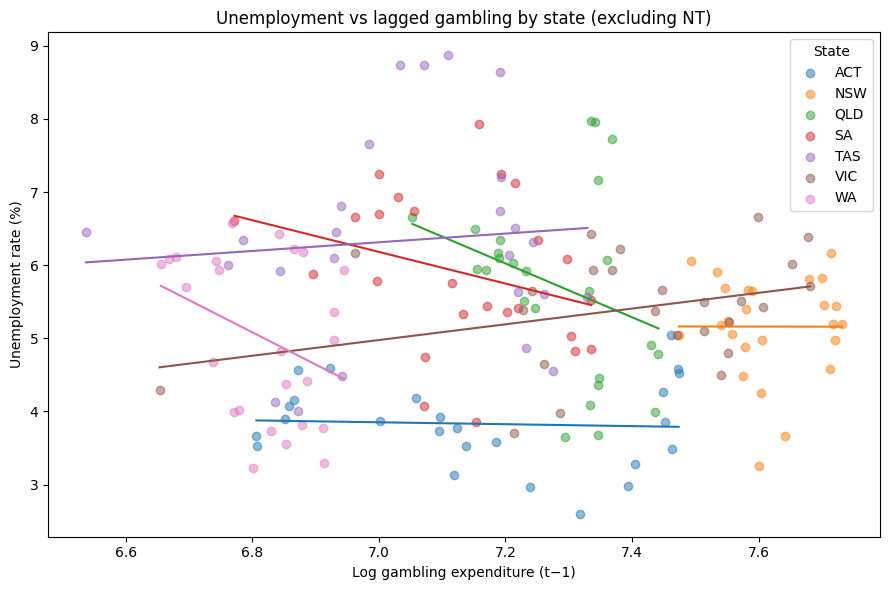

In [43]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df.reset_index().copy()

# Exclude NT (adjust label if needed)
df_plot = df_plot[df_plot["State"] != "NT"]

# Create lagged gambling
df_plot["g_lag"] = df_plot.groupby("State")["log_gambling"].shift(1)

df_plot = df_plot.dropna(subset=["g_lag", UNEMP])

print("Final plot data shape:", df_plot.shape)

plt.figure(figsize=(9,6))

for state, d in df_plot.groupby("State"):
    if len(d) < 5:
        continue

    x = d["g_lag"]
    y = d[UNEMP]

    plt.scatter(x, y, alpha=0.5, label=state)

    b1, b0 = np.polyfit(x, y, 1)
    x_grid = np.linspace(x.min(), x.max(), 50)
    plt.plot(x_grid, b1*x_grid + b0)

plt.xlabel("Log gambling expenditure (t−1)")
plt.ylabel("Unemployment rate (%)")
plt.title("Unemployment vs lagged gambling by state (excluding NT)")
plt.legend(title="State")
plt.tight_layout()
plt.show()



This figure plots unemployment in year
𝑡 against log gambling expenditure in year
*t−1* for each Australian state, excluding the Northern Territory. Dots show annual state-level observations, while lines depict time-series OLS fits within states. The figure highlights substantial heterogeneity across regions: in some states, such as NSW and VIC, higher gambling expenditure in the previous year is associated with slightly higher subsequent unemployment, whereas in others, including SA and QLD, the relationship is negative. These differences indicate that the lagged association between gambling and labour-market outcomes is not uniform across states. The relationship varies by regional economic structure and gambling environments, motivating the use of pooled panel regressions to estimate an average effect while controlling for unobserved regional characteristics.

**Model A3: 8-region panel** (main regional analysis)

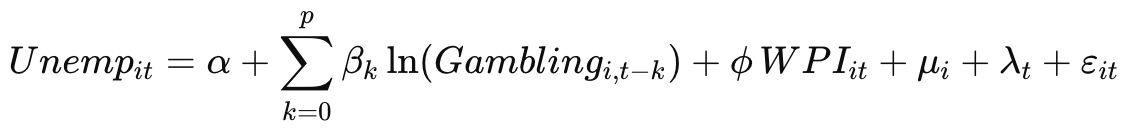

**Note:** We only use panel regression when we have both **cross-sectional** and **time-series** data. In this case, it only works when we include all 8 regions together with their time-series data.

In the previous section, I use time-series OLS because we do not use the cross-sectional dimension and instead examine one region at a time.


Panel model tells “Within regions, does gambling lead unemployment **after accounting for regional differences and national shocks?**”

**The error terms**

**1. μ_i:** Region fixed effects = everything about that region that does NOT change over time

“Controls for things that make NSW permanently different from WA.”

Examples: Cultural attitudes toward gambling, Long-run industry structure (e.g. mining-heavy WA), Historical labour-market characteristics, etc

These factors differ across regions but are constant over time within each region.

**2. λ_t:** Year fixed effects = everything that affects all regions in year

“Controls for things that affect all regions in a given year, like COVID.”

Examples: National recessions / booms, COVID, Interest-rate cycles, etc.

So if unemployment and gambling both spike in 2020: that variation is absorbed by 𝜆 not attributed to gambling causing unemployment

**3.ε_it:** Idiosyncratic shocks = unexpected region–year noise

“Everything else we can’t explain.”

Examples: A local factory closure, A temporary regional event, Measurement error, etc.

In [14]:
# 2) PANEL FE
def panel_fe_modelA(df_panel, *, p=1, states=None):

    # ensure MultiIndex
    d = df_panel.copy()
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()

    # optional subset of states (>=2)
    if states is not None:
        if isinstance(states, str):
            states = [states]
        d = d.loc[d.index.get_level_values(0).isin(states)].copy()

    # lags within state: k=0..p
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d.groupby(level=0)["log_gambling"].shift(k)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP]
    X = d[rhs]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)
    return res

In [15]:
# How to call it
# ---- 8-region PANEL FE ----
res_panel = panel_fe_modelA(df, p=5) # change p here for different lags
print(res_panel.summary)

                            PanelOLS Estimation Summary                            
Dep. Variable:     Unemployment rate (%)   R-squared:                        0.2211
Estimator:                      PanelOLS   R-squared (Between):             -12.598
No. Observations:                    168   R-squared (Within):              -7.1641
Date:                   Mon, Dec 29 2025   R-squared (Overall):             -12.449
Time:                           21:32:49   Log-likelihood                   -110.60
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      5.3922
Entities:                              8   P-value                           0.0000
Avg Obs:                          21.000   Distribution:                   F(7,133)
Min Obs:                          21.000                                           
Max Obs:                          21.000   F-statistic (robust):            

**3.1.B Model B: Gambling lags unemployment**

Test of unemployment → later gambling




This part should be really easy to understand if you understand 3.1.A, we are just switching the dependent and independent variables.
Therefore, I'll simplify the explanation ;)



**Model B1 and B2: Time-series OLS run at National and Regional level**

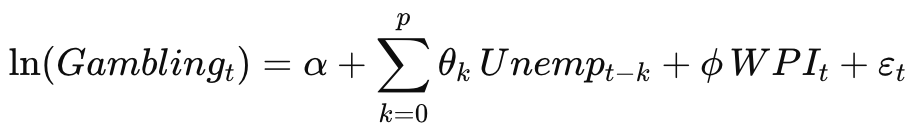

In [16]:
def ts_ols_modelB(ts_df, *, year_col, p=1):
    # Same cleaning pattern as Model A
    d = ts_df[[year_col, UNEMP, "log_gambling", WPI]].dropna().sort_values(year_col).copy()

    # Only change vs Model A: lag unemployment instead of gambling
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    # Only change vs Model A: y is log_gambling
    y = d["log_gambling"].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [17]:
# Call Model B1
# National
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()

res_nat_B, used_nat_B = ts_ols_modelB(nat, year_col=YEAR, p=2)# change p here
print(res_nat_B.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     11.41
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           6.86e-05
Time:                        21:32:49   Log-Likelihood:                 29.312
No. Observations:                  24   AIC:                            -48.62
Df Residuals:                      19   BIC:                            -42.73
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.0405      0.187  

In [18]:
#Call Model B2
# Regional
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]] # change region here

res_nsw_B, used_nsw_B = ts_ols_modelB(region, year_col=YEAR, p=2)# change p here
print(res_nsw_B.summary())



                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     4.724
Date:                Mon, 29 Dec 2025   Prob (F-statistic):            0.00813
Time:                        21:32:49   Log-Likelihood:                 36.177
No. Observations:                  24   AIC:                            -62.35
Df Residuals:                      19   BIC:                            -56.46
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.8646      0.265  

**Model B3: 8-region panel**

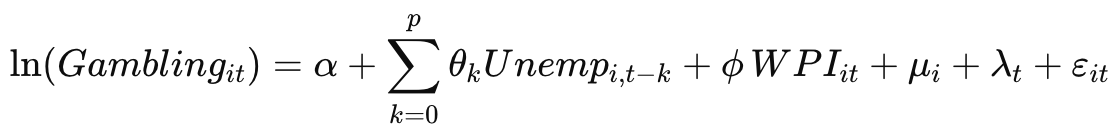

In [19]:
def panel_modelB(df_panel, *, p=1):

    d = df_panel.copy()

    # Lags of unemployment: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"]
    X = d[rhs]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    return mod.fit(cov_type="clustered", cluster_entity=True)

In [20]:
# call panel
resB_panel = panel_modelB(df, p=5)
print(resB_panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.2509
Estimator:                   PanelOLS   R-squared (Between):             -1.4533
No. Observations:                 168   R-squared (Within):              -2.0753
Date:                Mon, Dec 29 2025   R-squared (Overall):             -1.4542
Time:                        21:32:49   Log-likelihood                    21.184
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.3653
Entities:                           8   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(7,133)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             142.08
                            

All of the models in Section 3.1 only provide information about **correlation**. To further examine whether a **causal** relationship exists, we employ Granger causality analysis.

What “Granger causality” actually means is not philosophical causality. Instead, it asks a specific and testable question:

Do past values of gambling improve our ability to predict unemployment, over and above unemployment’s own past values?

If yes, gambling is said to Granger-cause unemployment.

But the good news is that Granger causality is much simpler than Section 3.1, where we used combined OLS and panel regression. For the panel analysis, we use the same equation and model structure for both national-level and regional-level data, and we simply switch the dependent and independent variables.

# 3.2 Granger causality analysis

3.2.C Model C: Gambling Granger-causes unemployment
* supports gambling leads unemployment

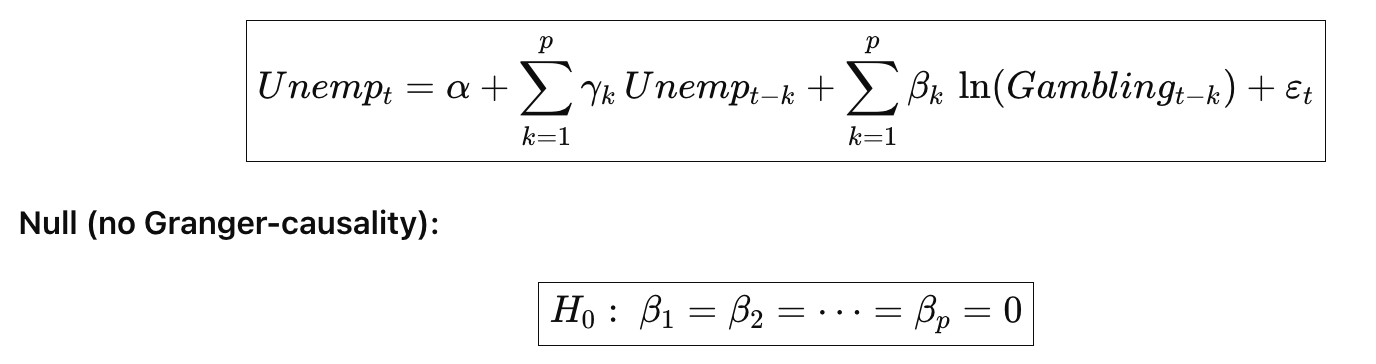

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_C_gambling_to_unemp(ts_df, *, year_col, maxlag=2):
    """
    Model C: Does gambling Granger-cause unemployment?
    Tests whether lagged log_gambling helps predict UNEMP beyond lagged UNEMP.

    ts_df must have columns: year_col, UNEMP, log_gambling
    Returns: DataFrame with p-values by lag (ssr_ftest)
    """
    d = ts_df[[year_col, UNEMP, "log_gambling"]].dropna().sort_values(year_col).copy()

    # IMPORTANT: order must be [Y, X] where we test X -> Y
    data = d[[UNEMP, "log_gambling"]]

    res = grangercausalitytests(data, maxlag=maxlag, verbose=False)

    out = []
    for lag in range(1, maxlag + 1):
        pval = res[lag][0]["ssr_ftest"][1]   # p-value
        out.append({"lag": lag, "p_value": pval})

    return pd.DataFrame(out)


In [22]:
# Call with National Data
df_flat = df.reset_index()

nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()

gc_nat_C = granger_C_gambling_to_unemp(nat, year_col=YEAR, maxlag=5)  # change maxlag here
print("National C (gambling -> unemp):")
print(gc_nat_C)

National C (gambling -> unemp):
   lag   p_value
0    1  0.751484
1    2  0.013271
2    3  0.009070
3    4  0.007865
4    5  0.009009


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [23]:
# Call with Regional Data
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]]# change "NSW" for other regions

gc_region_C = granger_C_gambling_to_unemp(region, year_col=YEAR, maxlag=5)  # change maxlag here
print( "Regional C (gambling -> unemp):")
print(gc_region_C)

Regional C (gambling -> unemp):
   lag   p_value
0    1  0.543998
1    2  0.077361
2    3  0.011996
3    4  0.048649
4    5  0.057756


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


3.2.D Model D2: Unemployment Granger-causes gambling
* supports gambling lags unemployment

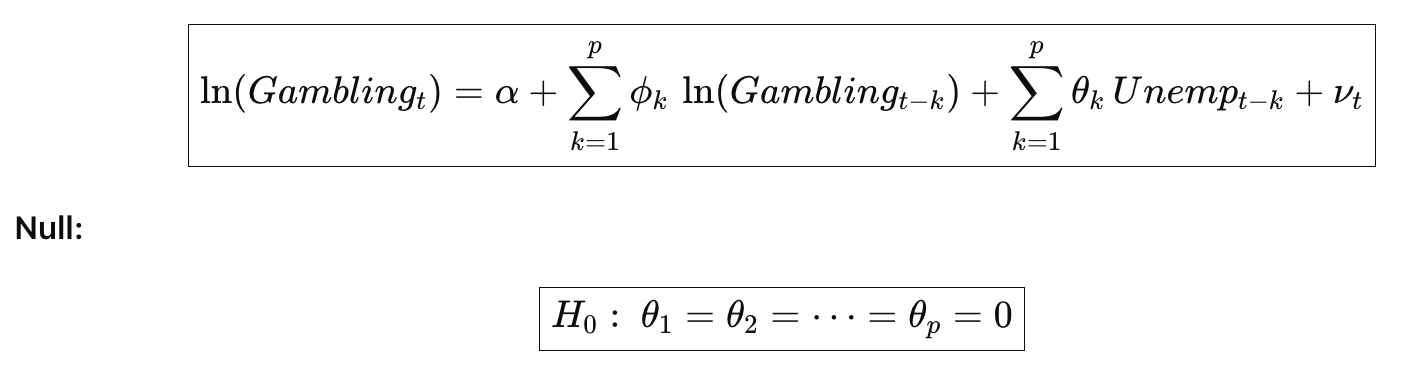

In [24]:
def granger_D_unemp_to_gambling(ts_df, *, year_col, maxlag=2):
    """
    Model D: Does unemployment Granger-cause gambling?
    Tests whether lagged UNEMP helps predict log_gambling beyond lagged log_gambling.

    ts_df must have columns: year_col, UNEMP, log_gambling
    Returns: DataFrame with p-values by lag (ssr_ftest)
    """
    d = ts_df[[year_col, UNEMP, "log_gambling"]].dropna().sort_values(year_col).copy()

    # order must be [Y, X] where we test X -> Y
    data = d[["log_gambling", UNEMP]]

    res = grangercausalitytests(data, maxlag=maxlag, verbose=False)

    out = []
    for lag in range(1, maxlag + 1):
        pval = res[lag][0]["ssr_ftest"][1]
        out.append({"lag": lag, "p_value": pval})

    return pd.DataFrame(out)

In [25]:
# Call with National Data
gc_nat_D = granger_D_unemp_to_gambling(nat, year_col=YEAR, maxlag=2)
print("\nNational D (unemp -> gambling):")
print(gc_nat_D)



National D (unemp -> gambling):
   lag   p_value
0    1  0.310783
1    2  0.584895


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [26]:
# Call with regional Data
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]]# change "NSW" for other regions here
gc_region_D = granger_D_unemp_to_gambling(region, year_col=YEAR, maxlag=4)  # change maxlag here
print("\nRegion D (unemp -> gambling):")
print(gc_region_D)


Region D (unemp -> gambling):
   lag   p_value
0    1  0.136219
1    2  0.132861
2    3  0.372306
3    4  0.372384


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


To summarise, we have two parts in our method.

Part 1 tests for correlation using time-series OLS (national and regional) and panel regression (national).

Part 2 tests for causation using Granger causality (national and regional).

Please tell me anything you think may be we should add or delete:), also here are some things to think about:

1. For control vairables, I am only use WPI here, should we add more? If so, what else should we add?

1. I am thinking about may be choose one from Times-series OLS at the national level and panel regression at the national level, maybe we should subtract the OLS at national level?

2. Suppose in part 1 we find unemp => later gambling, may be for part 2, we should only do does unemp granger cause later gambling? Otherwise, we could end up in a situation of not significant correlation but significant causation?  

In [27]:
# 1. Set panel index
df_p = df.copy()

# 2. Define variables
y = df_p[GAMB]                 # gambling is dependent
X = df_p[[UNEMP, WPI]]         # unemployment + control(s)
X = sm.add_constant(X)

# 3. Two-way fixed effects panel
model = PanelOLS(
    y,
    X,
    entity_effects=True,       # region FE
    time_effects=True          # year FE
)

# 4. Two-way clustered standard errors
res = model.fit(
    cov_type="clustered",
    cluster_entity=True,       # cluster by region
    cluster_time=True          # cluster by year
)

print(res.summary)

                                           PanelOLS Estimation Summary                                            
Dep. Variable:     Real per capita total gambling expenditure value ($)   R-squared:                        0.0042
Estimator:                                                     PanelOLS   R-squared (Between):              0.0461
No. Observations:                                                   208   R-squared (Within):              -1.7073
Date:                                                  Mon, Dec 29 2025   R-squared (Overall):             -0.8983
Time:                                                          21:32:50   Log-likelihood                   -1790.5
Cov. Estimator:                                               Clustered                                           
                                                                          F-statistic:                      0.3627
Entities:                                                             8   P-valu

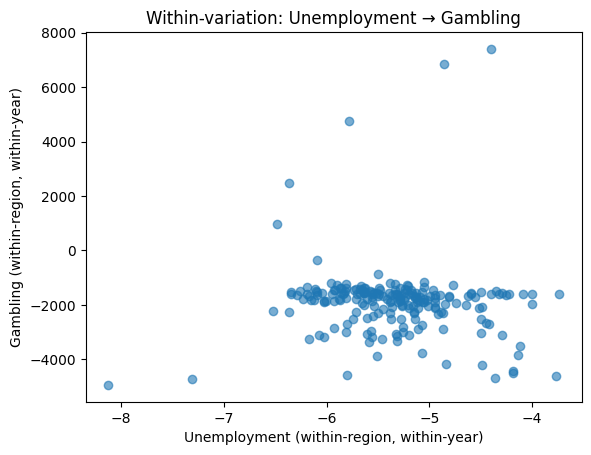

In [28]:
# Demean by region and year
df_plot = df_p.copy()

df_plot['gamb_within'] = (
    df_plot[GAMB]
    - df_plot.groupby(STATE)[GAMB].transform('mean')
    - df_plot.groupby(YEAR)[GAMB].transform('mean')
)

df_plot['unemp_within'] = (
    df_plot[UNEMP]
    - df_plot.groupby(STATE)[UNEMP].transform('mean')
    - df_plot.groupby(YEAR)[UNEMP].transform('mean')
)

plt.figure()
plt.scatter(df_plot['unemp_within'], df_plot['gamb_within'], alpha=0.6)
plt.xlabel('Unemployment (within-region, within-year)')
plt.ylabel('Gambling (within-region, within-year)')
plt.title('Within-variation: Unemployment → Gambling')
plt.show()

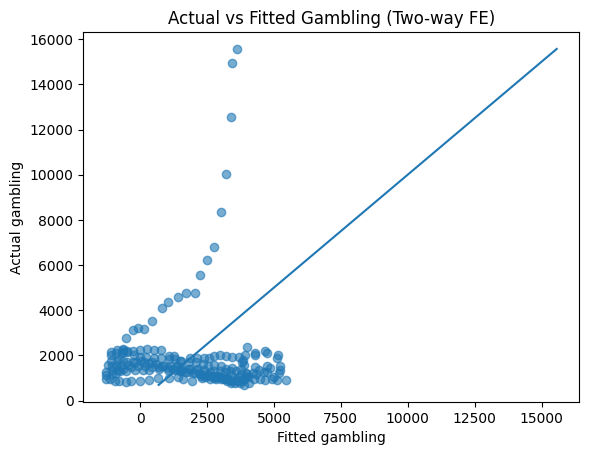

In [29]:
df_plot['fitted'] = res.fitted_values

plt.figure()
plt.scatter(df_plot['fitted'], df_plot[GAMB], alpha=0.6)
plt.plot(
    [df_plot[GAMB].min(), df_plot[GAMB].max()],
    [df_plot[GAMB].min(), df_plot[GAMB].max()]
)
plt.xlabel('Fitted gambling')
plt.ylabel('Actual gambling')
plt.title('Actual vs Fitted Gambling (Two-way FE)')
plt.show()


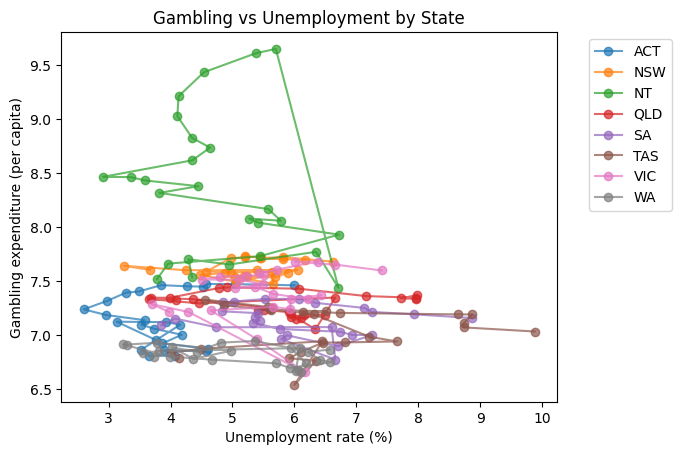

In [30]:
plt.figure()

for state, g in df.groupby(STATE):
    plt.plot(
        g[UNEMP],
        g["log_gambling"],
        marker='o',
        alpha=0.7,
        label=state
    )

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Gambling expenditure (per capita)')
plt.title('Gambling vs Unemployment by State')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

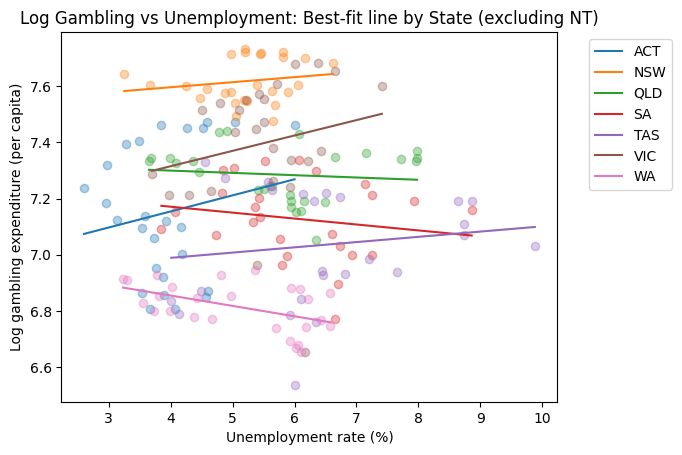

In [31]:
plt.figure()

for state, g in df.groupby(STATE):

    if state == "NT":   # ⬅️ exclude Northern Territory
        continue

    g = g[[UNEMP, "log_gambling"]].dropna()
    if len(g) < 2:
        continue

    # scatter points (optional)
    plt.scatter(g[UNEMP], g["log_gambling"], alpha=0.35)

    # best-fit line: log_gambling = a + b * UNEMP
    b, a = np.polyfit(
        g[UNEMP].to_numpy(),
        g["log_gambling"].to_numpy(),
        1
    )

    x = np.linspace(g[UNEMP].min(), g[UNEMP].max(), 50)
    y = a + b * x

    plt.plot(x, y, label=state)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Log gambling expenditure (per capita)')
plt.title('Log Gambling vs Unemployment: Best-fit line by State (excluding NT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


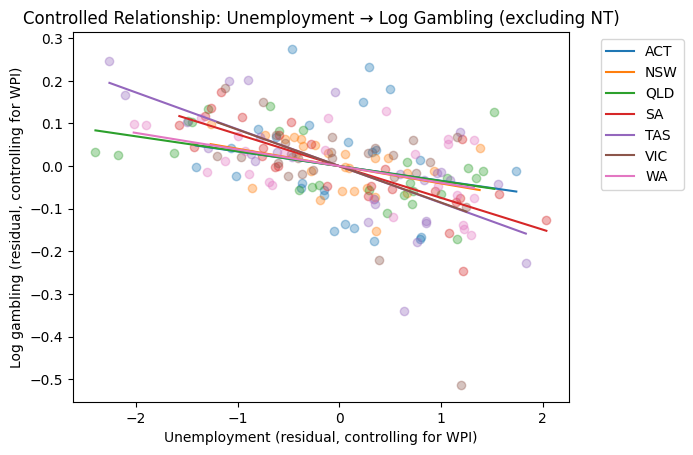

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.figure()

for state, g in df.groupby(STATE):

    if state == "NT":   # exclude NT
        continue

    g = g[[UNEMP, "log_gambling", WPI]].dropna()
    if len(g) < 3:
        continue

    # 1️⃣ Partial out WPI from log gambling
    X_wpi = sm.add_constant(g[WPI])
    res_gamb = sm.OLS(g["log_gambling"], X_wpi).fit().resid

    # 2️⃣ Partial out WPI from unemployment
    res_unemp = sm.OLS(g[UNEMP], X_wpi).fit().resid

    # 3️⃣ Scatter residuals
    plt.scatter(res_unemp, res_gamb, alpha=0.35)

    # 4️⃣ Best-fit line on residuals
    b, a = np.polyfit(res_unemp.to_numpy(), res_gamb.to_numpy(), 1)

    x = np.linspace(res_unemp.min(), res_unemp.max(), 50)
    y = a + b * x

    plt.plot(x, y, label=state)

plt.xlabel('Unemployment (residual, controlling for WPI)')
plt.ylabel('Log gambling (residual, controlling for WPI)')
plt.title('Controlled Relationship: Unemployment → Log Gambling (excluding NT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


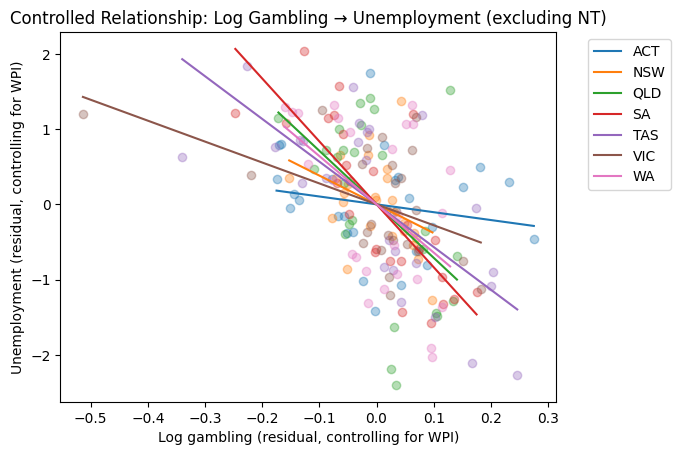

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.figure()

for state, g in df.groupby(STATE):

    if state == "NT":   # exclude Northern Territory
        continue

    g = g[[UNEMP, "log_gambling", WPI]].dropna()
    if len(g) < 3:
        continue

    # 1️⃣ Partial out WPI from unemployment (NOW the dependent variable)
    X_wpi = sm.add_constant(g[WPI])
    res_unemp = sm.OLS(g[UNEMP], X_wpi).fit().resid

    # 2️⃣ Partial out WPI from log gambling (NOW the independent variable)
    res_gamb = sm.OLS(g["log_gambling"], X_wpi).fit().resid

    # 3️⃣ Scatter residuals
    plt.scatter(res_gamb, res_unemp, alpha=0.35)

    # 4️⃣ Best-fit line on residuals
    b, a = np.polyfit(
        res_gamb.to_numpy(),
        res_unemp.to_numpy(),
        1
    )

    x = np.linspace(res_gamb.min(), res_gamb.max(), 50)
    y = a + b * x

    plt.plot(x, y, label=state)

plt.xlabel('Log gambling (residual, controlling for WPI)')
plt.ylabel('Unemployment (residual, controlling for WPI)')
plt.title('Controlled Relationship: Log Gambling → Unemployment (excluding NT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


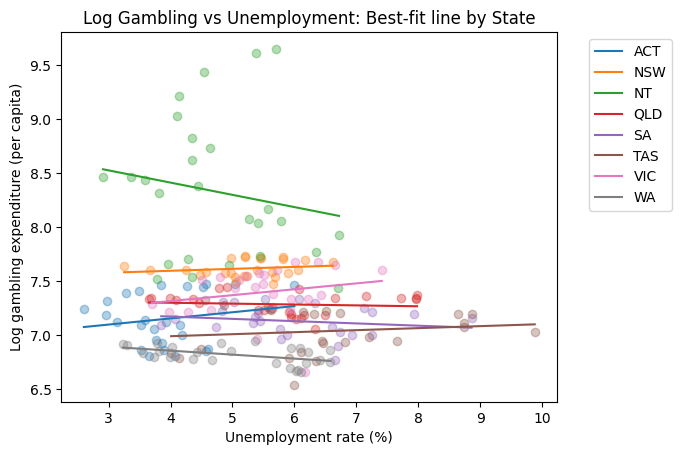

In [34]:
plt.figure()

for state, g in df.groupby(STATE):
    g = g[[UNEMP, "log_gambling"]].dropna()
    if len(g) < 2:
        continue

    # scatter points (optional; remove if you only want lines)
    plt.scatter(g[UNEMP], g["log_gambling"], alpha=0.35)

    # best-fit line: log_GAMB = a + b * UNEMP
    b, a = np.polyfit(g[UNEMP].to_numpy(), g["log_gambling"].to_numpy(), 1)

    x = np.linspace(g[UNEMP].min(), g[UNEMP].max(), 50)
    y = a + b * x

    plt.plot(x, y, label=state)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Log gambling expenditure (per capita)')
plt.title('Log Gambling vs Unemployment: Best-fit line by State')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

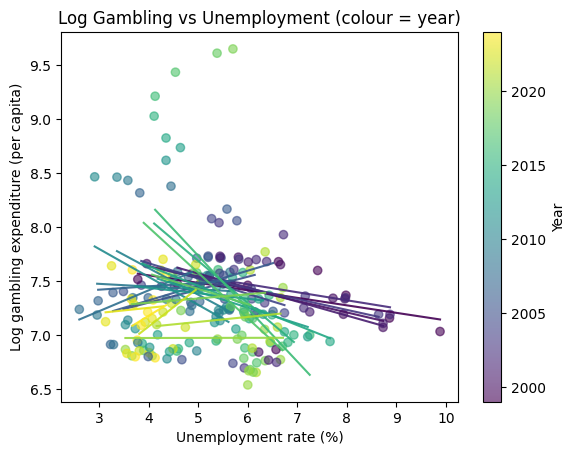

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure()

# Extract year values from index (numeric!)
years = df.index.get_level_values(YEAR).astype(int)

# Set up colormap properly
norm = mpl.colors.Normalize(vmin=years.min(), vmax=years.max())
cmap = plt.cm.viridis

# 1️⃣ Scatter: colour corresponds to year of each observation
sc = plt.scatter(
    df[UNEMP],
    df['log_gambling'],
    c=years,              # IMPORTANT: pass year here
    cmap=cmap,
    norm=norm,
    alpha=0.6
)

# 2️⃣ Best-fit line for each year (same colour as that year)
unique_years = np.sort(years.unique())

for yr in unique_years:
    g = df[df.index.get_level_values(YEAR) == yr][[UNEMP, 'log_gambling']].dropna()
    if len(g) < 2:
        continue

    x = g[UNEMP].to_numpy()
    y = g['log_gambling'].to_numpy()

    b, a = np.polyfit(x, y, 1)
    xgrid = np.linspace(x.min(), x.max(), 50)

    plt.plot(
        xgrid,
        a + b * xgrid,
        color=cmap(norm(yr)),   # same colour as dots for that year
        alpha=0.9
    )

# 3️⃣ Colorbar that truly represents YEAR
cbar = plt.colorbar(sc)
cbar.set_label('Year')
cbar.ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Log gambling expenditure (per capita)')
plt.title('Log Gambling vs Unemployment (colour = year)')
plt.show()


In [36]:
df

Real per capita total gambling expenditure value ($)  \
State year                                                         
ACT   1999                                            1739.17      
      2000                                            1757.75      
      2001                                            1761.04      
      2002                                            1718.74      
      2003                                            1723.14      
...                                                       ...      
WA    2020                                             787.04      
      2021                                             971.28      
      2022                                             946.83      
      2023                                             925.11      
      2024                                             896.41      

            Unemployment rate (%)  Wage price index  log_gambling  
State year                                                         
ACT   1999                   6.00             69.25      7.461163  
      2000                   5.04             70.98      7.471790  
      2001                   4.58             73.50      7.473660  
      2002                   4.52             75.80      7.449347  
      2003                   4.26             78.40      7.451903  
...                           ...               ...           ...  
WA    2020                   6.02            132.48      6.668279  
      2021                   6.09            134.43      6.878615  
      2022                   3.81            137.35      6.853120  
      2023                   3.56            142.58      6.829913  
      2024                   3.73            148.85      6.798398  

[208 rows x 4 columns]

In [37]:
df[YEAR]

KeyError: 'year'